<a href="https://colab.research.google.com/github/ttezy/Time-Sequence-Analysis/blob/main/LSTM_Multivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 1: Load data**
## **You may need to upload pollution.csv to /content/pollution.csv**

## **Import libs**

In [13]:
from matplotlib import pyplot as plt
import numpy as np

import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from numpy import concatenate
from math import sqrt

## **Load dataset**

In [14]:
df=pd.read_csv('pollution.csv',header=0, index_col=0)
df

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,0.0,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,0.0,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,0.0,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,0.0,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,0.0,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


## **Visualize data**

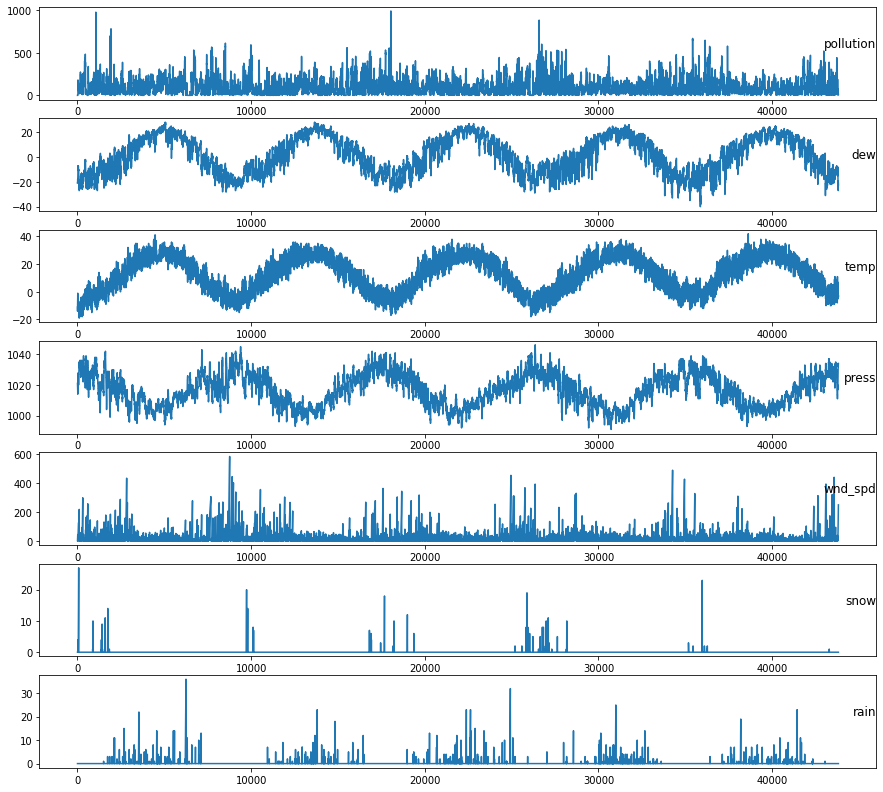

In [15]:
values = df.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure(figsize = (15, 14))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

# **Step 2: Prepare for model**

## **1 past step to predict 1 future step**





## **Encode wind direction**

In [16]:
# integer encode direction
encoder = LabelEncoder()
values[:, 4] = encoder.fit_transform(values[:, 4])
# ensure all data is float
values = values.astype('float32')

df['wnd_dir'] = values[:, 4]

df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,0.0,-21,-11.0,1021.0,1.0,1.79,0,0
2010-01-01 01:00:00,0.0,-21,-12.0,1020.0,1.0,4.92,0,0
2010-01-01 02:00:00,0.0,-21,-11.0,1019.0,1.0,6.71,0,0
2010-01-01 03:00:00,0.0,-21,-14.0,1019.0,1.0,9.84,0,0
2010-01-01 04:00:00,0.0,-20,-12.0,1018.0,1.0,12.97,0,0


## **Normalize data values between 0 and 1**

In [17]:
values = df.values
y_true = values[int(len(values) * 0.9):, 0] # store y_true before the data is scaled

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

## **Reframe dataset for supervised learning**

In [18]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i)[0])
        if i == 0:
            names += ['var1(t)' ]
        else:
            names += [('var1(t+%d)' % (i))]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [19]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var7(t-1)  var8(t-1)  var1(t)
1        0.0   0.279412   0.131148  ...        0.0        0.0      0.0
2        0.0   0.279412   0.114754  ...        0.0        0.0      0.0
3        0.0   0.279412   0.131148  ...        0.0        0.0      0.0
4        0.0   0.279412   0.081967  ...        0.0        0.0      0.0
5        0.0   0.294118   0.114754  ...        0.0        0.0      0.0

[5 rows x 9 columns]


## **Split training and testing data**

In [20]:
# split into train and test sets
values = reframed.values

# use first 90% data to train
n_train_hours = int(len(values) * 0.9)
train = values[:n_train_hours]
test = values[n_train_hours:]

# split into input and output (var(t-1), var1(t))
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print("train_X shape: ", train_X.shape, " train_y shape: ", train_y.shape,
      "\ntest_X shape: ", test_X.shape, " test_y shape: ", test_y.shape)

train_X shape:  (39440, 1, 8)  train_y shape:  (39440,) 
test_X shape:  (4383, 1, 8)  test_y shape:  (4383,)


# **Step 3: Train LSTM(Long Short-term Memory) model**

## **Design network**

In [21]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

## **Fit model**

In [22]:
epochs = 50 # modify here to choose training epoches
history = model.fit(train_X, train_y, epochs=epochs, batch_size=72, validation_data=(test_X, test_y), verbose=2,
                    shuffle=False)

Epoch 1/50
548/548 - 3s - loss: 0.0346 - val_loss: 0.0277
Epoch 2/50
548/548 - 1s - loss: 0.0157 - val_loss: 0.0148
Epoch 3/50
548/548 - 1s - loss: 0.0140 - val_loss: 0.0125
Epoch 4/50
548/548 - 1s - loss: 0.0139 - val_loss: 0.0120
Epoch 5/50
548/548 - 1s - loss: 0.0138 - val_loss: 0.0118
Epoch 6/50
548/548 - 1s - loss: 0.0139 - val_loss: 0.0118
Epoch 7/50
548/548 - 1s - loss: 0.0138 - val_loss: 0.0117
Epoch 8/50
548/548 - 1s - loss: 0.0138 - val_loss: 0.0117
Epoch 9/50
548/548 - 1s - loss: 0.0138 - val_loss: 0.0117
Epoch 10/50
548/548 - 1s - loss: 0.0138 - val_loss: 0.0117
Epoch 11/50
548/548 - 1s - loss: 0.0138 - val_loss: 0.0117
Epoch 12/50
548/548 - 1s - loss: 0.0138 - val_loss: 0.0117
Epoch 13/50
548/548 - 1s - loss: 0.0138 - val_loss: 0.0118
Epoch 14/50
548/548 - 1s - loss: 0.0138 - val_loss: 0.0117
Epoch 15/50
548/548 - 1s - loss: 0.0138 - val_loss: 0.0118
Epoch 16/50
548/548 - 1s - loss: 0.0138 - val_loss: 0.0117
Epoch 17/50
548/548 - 1s - loss: 0.0138 - val_loss: 0.0118
Epoch 

## **Show the training loss and test loss**

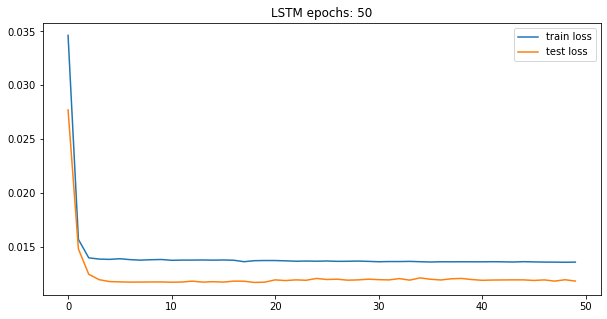

In [23]:
# plot history
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.title("LSTM epochs: " + str(epochs))
plt.legend()
plt.show()

# **Step 4: Implement Data Forecasting**

## **Predict future 1-step data based on past 1-step data**

In [24]:
yhat = model.predict(test_X)

## **inverse transform the prediction and the test_y**

In [25]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

## **Calculate RMSE**

In [26]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 22.094


## **Show first 200 predictions**

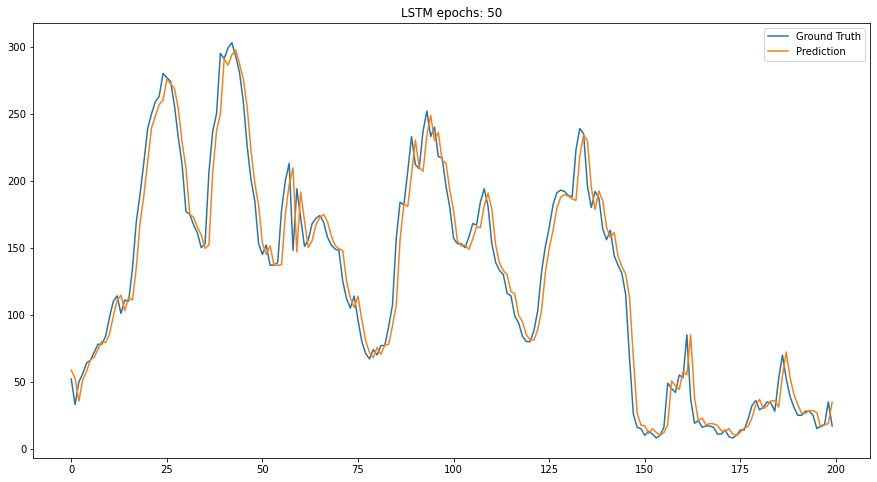

In [27]:
plt.figure(figsize=(15, 8))
plt.plot(inv_y[:200], label='Ground Truth')
plt.plot(inv_yhat[:200], label='Prediction')
plt.title("LSTM epochs: " + str(epochs))
plt.legend()
plt.show()

## **Show first 2000 predictions**

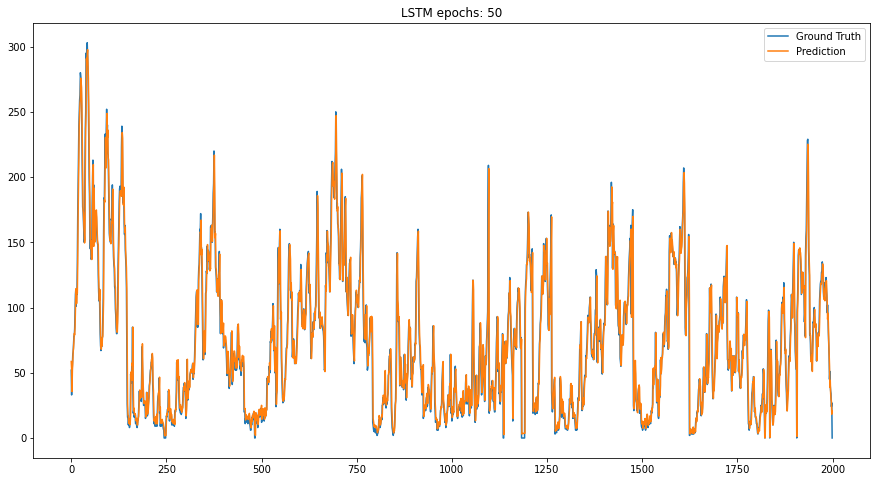

In [28]:
plt.figure(figsize=(25, 5))
plt.plot(inv_y[:2000], label='Ground Truth')
plt.plot(inv_yhat[:2000], label='Prediction')
plt.title("LSTM epochs: " + str(epochs))
plt.legend()
plt.show()

# **Step 5: Test forecasting ability for more future time**

pastStep:  24  futureStep:  1 (39420, 1, 192) (39420, 1) (4380, 1, 192) (4380, 1)
Epoch 1/50
548/548 - 3s - loss: 0.0360 - val_loss: 0.0257
Epoch 2/50
548/548 - 1s - loss: 0.0227 - val_loss: 0.0215
Epoch 3/50
548/548 - 1s - loss: 0.0223 - val_loss: 0.0177
Epoch 4/50
548/548 - 1s - loss: 0.0206 - val_loss: 0.0162
Epoch 5/50
548/548 - 1s - loss: 0.0200 - val_loss: 0.0151
Epoch 6/50
548/548 - 1s - loss: 0.0189 - val_loss: 0.0154
Epoch 7/50
548/548 - 1s - loss: 0.0185 - val_loss: 0.0150
Epoch 8/50
548/548 - 1s - loss: 0.0180 - val_loss: 0.0149
Epoch 9/50
548/548 - 1s - loss: 0.0175 - val_loss: 0.0136
Epoch 10/50
548/548 - 1s - loss: 0.0176 - val_loss: 0.0142
Epoch 11/50
548/548 - 1s - loss: 0.0172 - val_loss: 0.0144
Epoch 12/50
548/548 - 1s - loss: 0.0168 - val_loss: 0.0133
Epoch 13/50
548/548 - 1s - loss: 0.0166 - val_loss: 0.0139
Epoch 14/50
548/548 - 1s - loss: 0.0168 - val_loss: 0.0135
Epoch 15/50
548/548 - 1s - loss: 0.0165 - val_loss: 0.0135
Epoch 16/50
548/548 - 1s - loss: 0.0162 - 

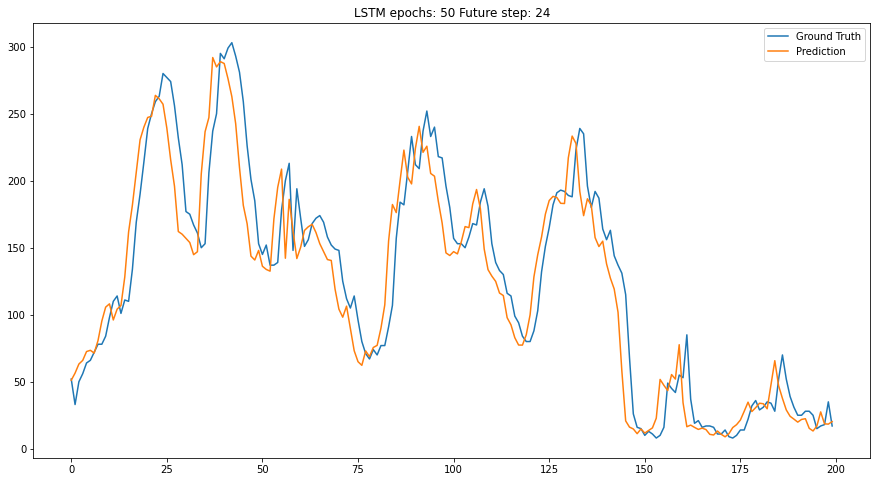

pastStep:  24  futureStep:  2 (39419, 1, 192) (39419, 2) (4380, 1, 192) (4380, 2)
Epoch 1/50
548/548 - 3s - loss: 0.0395 - val_loss: 0.0262
Epoch 2/50
548/548 - 1s - loss: 0.0273 - val_loss: 0.0215
Epoch 3/50
548/548 - 1s - loss: 0.0244 - val_loss: 0.0208
Epoch 4/50
548/548 - 1s - loss: 0.0235 - val_loss: 0.0191
Epoch 5/50
548/548 - 1s - loss: 0.0228 - val_loss: 0.0211
Epoch 6/50
548/548 - 1s - loss: 0.0217 - val_loss: 0.0211
Epoch 7/50
548/548 - 1s - loss: 0.0214 - val_loss: 0.0188
Epoch 8/50
548/548 - 1s - loss: 0.0210 - val_loss: 0.0189
Epoch 9/50
548/548 - 1s - loss: 0.0211 - val_loss: 0.0193
Epoch 10/50
548/548 - 1s - loss: 0.0206 - val_loss: 0.0187
Epoch 11/50
548/548 - 1s - loss: 0.0205 - val_loss: 0.0193
Epoch 12/50
548/548 - 1s - loss: 0.0200 - val_loss: 0.0185
Epoch 13/50
548/548 - 1s - loss: 0.0202 - val_loss: 0.0187
Epoch 14/50
548/548 - 1s - loss: 0.0195 - val_loss: 0.0183
Epoch 15/50
548/548 - 1s - loss: 0.0197 - val_loss: 0.0180
Epoch 16/50
548/548 - 1s - loss: 0.0191 - 

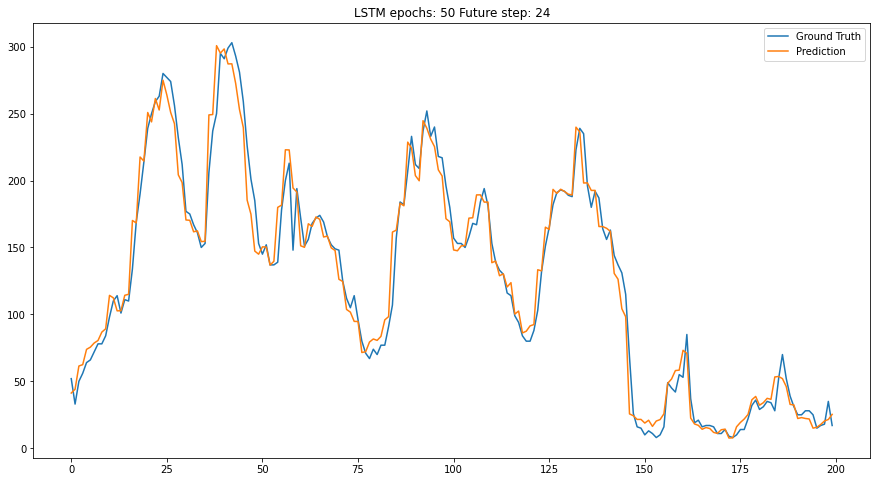

pastStep:  24  futureStep:  3 (39418, 1, 192) (39418, 3) (4380, 1, 192) (4380, 3)
Epoch 1/50
548/548 - 3s - loss: 0.0415 - val_loss: 0.0298
Epoch 2/50
548/548 - 1s - loss: 0.0300 - val_loss: 0.0258
Epoch 3/50
548/548 - 1s - loss: 0.0277 - val_loss: 0.0249
Epoch 4/50
548/548 - 1s - loss: 0.0263 - val_loss: 0.0242
Epoch 5/50
548/548 - 1s - loss: 0.0257 - val_loss: 0.0236
Epoch 6/50
548/548 - 1s - loss: 0.0250 - val_loss: 0.0232
Epoch 7/50
548/548 - 1s - loss: 0.0245 - val_loss: 0.0224
Epoch 8/50
548/548 - 1s - loss: 0.0240 - val_loss: 0.0228
Epoch 9/50
548/548 - 1s - loss: 0.0237 - val_loss: 0.0226
Epoch 10/50
548/548 - 1s - loss: 0.0235 - val_loss: 0.0226
Epoch 11/50
548/548 - 1s - loss: 0.0232 - val_loss: 0.0221
Epoch 12/50
548/548 - 1s - loss: 0.0230 - val_loss: 0.0216
Epoch 13/50
548/548 - 1s - loss: 0.0228 - val_loss: 0.0218
Epoch 14/50
548/548 - 1s - loss: 0.0228 - val_loss: 0.0219
Epoch 15/50
548/548 - 1s - loss: 0.0225 - val_loss: 0.0215
Epoch 16/50
548/548 - 1s - loss: 0.0225 - 

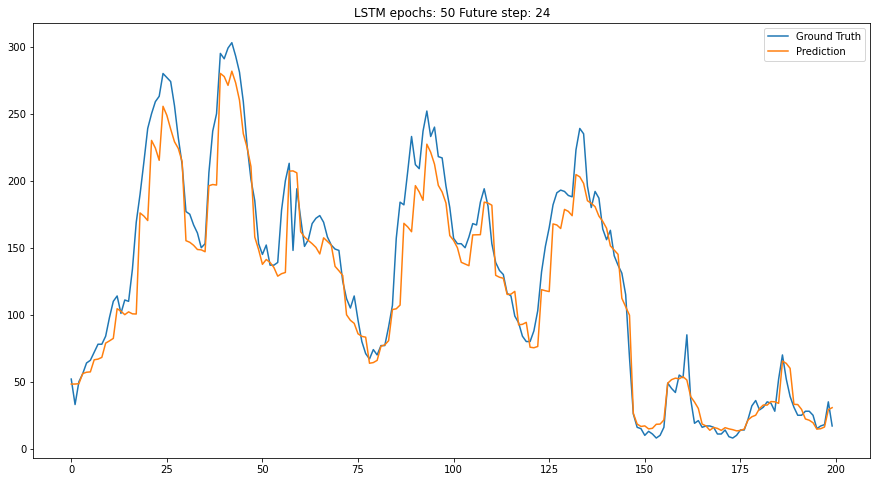

pastStep:  24  futureStep:  4 (39417, 1, 192) (39417, 4) (4380, 1, 192) (4380, 4)
Epoch 1/50
548/548 - 3s - loss: 0.0418 - val_loss: 0.0319
Epoch 2/50
548/548 - 1s - loss: 0.0323 - val_loss: 0.0277
Epoch 3/50
548/548 - 1s - loss: 0.0301 - val_loss: 0.0265
Epoch 4/50
548/548 - 1s - loss: 0.0290 - val_loss: 0.0256
Epoch 5/50
548/548 - 1s - loss: 0.0282 - val_loss: 0.0255
Epoch 6/50
548/548 - 1s - loss: 0.0276 - val_loss: 0.0256
Epoch 7/50
548/548 - 1s - loss: 0.0272 - val_loss: 0.0265
Epoch 8/50
548/548 - 1s - loss: 0.0269 - val_loss: 0.0296
Epoch 9/50
548/548 - 1s - loss: 0.0266 - val_loss: 0.0321
Epoch 10/50
548/548 - 1s - loss: 0.0263 - val_loss: 0.0305
Epoch 11/50
548/548 - 1s - loss: 0.0261 - val_loss: 0.0275
Epoch 12/50
548/548 - 1s - loss: 0.0259 - val_loss: 0.0253
Epoch 13/50
548/548 - 1s - loss: 0.0257 - val_loss: 0.0246
Epoch 14/50
548/548 - 1s - loss: 0.0255 - val_loss: 0.0242
Epoch 15/50
548/548 - 1s - loss: 0.0254 - val_loss: 0.0238
Epoch 16/50
548/548 - 1s - loss: 0.0252 - 

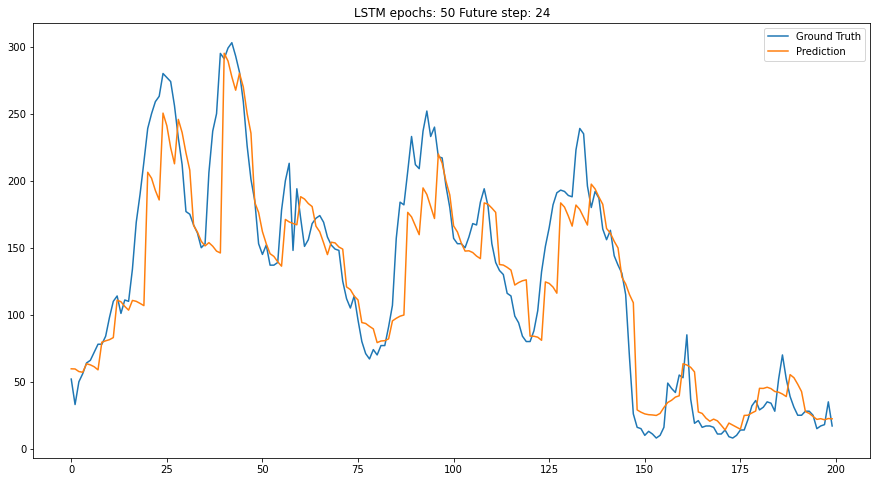

pastStep:  24  futureStep:  5 (39416, 1, 192) (39416, 5) (4380, 1, 192) (4380, 5)
Epoch 1/50
548/548 - 3s - loss: 0.0442 - val_loss: 0.0336
Epoch 2/50
548/548 - 1s - loss: 0.0341 - val_loss: 0.0301
Epoch 3/50
548/548 - 1s - loss: 0.0319 - val_loss: 0.0294
Epoch 4/50
548/548 - 1s - loss: 0.0309 - val_loss: 0.0292
Epoch 5/50
548/548 - 1s - loss: 0.0299 - val_loss: 0.0283
Epoch 6/50
548/548 - 1s - loss: 0.0294 - val_loss: 0.0298
Epoch 7/50
548/548 - 1s - loss: 0.0289 - val_loss: 0.0302
Epoch 8/50
548/548 - 1s - loss: 0.0286 - val_loss: 0.0300
Epoch 9/50
548/548 - 1s - loss: 0.0283 - val_loss: 0.0303
Epoch 10/50
548/548 - 1s - loss: 0.0282 - val_loss: 0.0284
Epoch 11/50
548/548 - 1s - loss: 0.0280 - val_loss: 0.0269
Epoch 12/50
548/548 - 1s - loss: 0.0279 - val_loss: 0.0264
Epoch 13/50
548/548 - 1s - loss: 0.0277 - val_loss: 0.0260
Epoch 14/50
548/548 - 1s - loss: 0.0275 - val_loss: 0.0258
Epoch 15/50
548/548 - 1s - loss: 0.0274 - val_loss: 0.0256
Epoch 16/50
548/548 - 1s - loss: 0.0272 - 

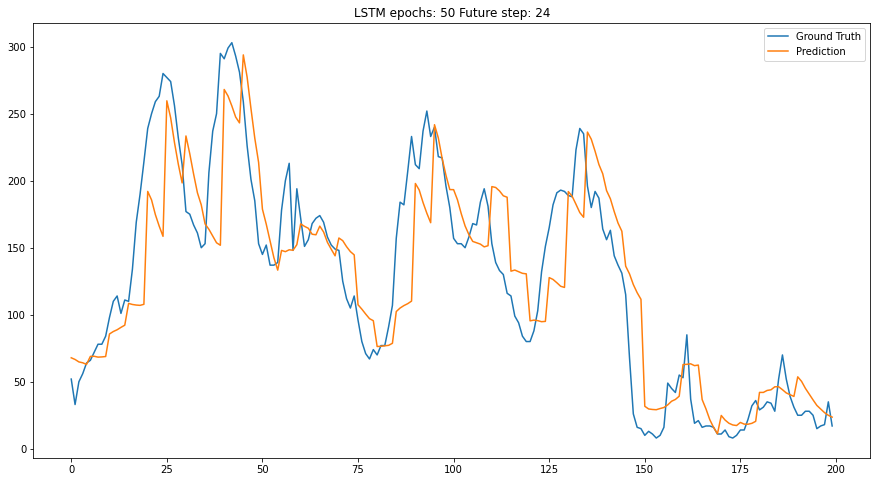

pastStep:  24  futureStep:  6 (39415, 1, 192) (39415, 6) (4380, 1, 192) (4380, 6)
Epoch 1/50
548/548 - 3s - loss: 0.0461 - val_loss: 0.0361
Epoch 2/50
548/548 - 1s - loss: 0.0360 - val_loss: 0.0323
Epoch 3/50
548/548 - 1s - loss: 0.0340 - val_loss: 0.0333
Epoch 4/50
548/548 - 1s - loss: 0.0328 - val_loss: 0.0322
Epoch 5/50
548/548 - 1s - loss: 0.0321 - val_loss: 0.0317
Epoch 6/50
548/548 - 1s - loss: 0.0314 - val_loss: 0.0307
Epoch 7/50
548/548 - 1s - loss: 0.0310 - val_loss: 0.0295
Epoch 8/50
548/548 - 1s - loss: 0.0307 - val_loss: 0.0290
Epoch 9/50
548/548 - 1s - loss: 0.0305 - val_loss: 0.0287
Epoch 10/50
548/548 - 1s - loss: 0.0302 - val_loss: 0.0285
Epoch 11/50
548/548 - 1s - loss: 0.0300 - val_loss: 0.0285
Epoch 12/50
548/548 - 1s - loss: 0.0298 - val_loss: 0.0281
Epoch 13/50
548/548 - 1s - loss: 0.0296 - val_loss: 0.0279
Epoch 14/50
548/548 - 1s - loss: 0.0294 - val_loss: 0.0276
Epoch 15/50
548/548 - 1s - loss: 0.0292 - val_loss: 0.0275
Epoch 16/50
548/548 - 1s - loss: 0.0290 - 

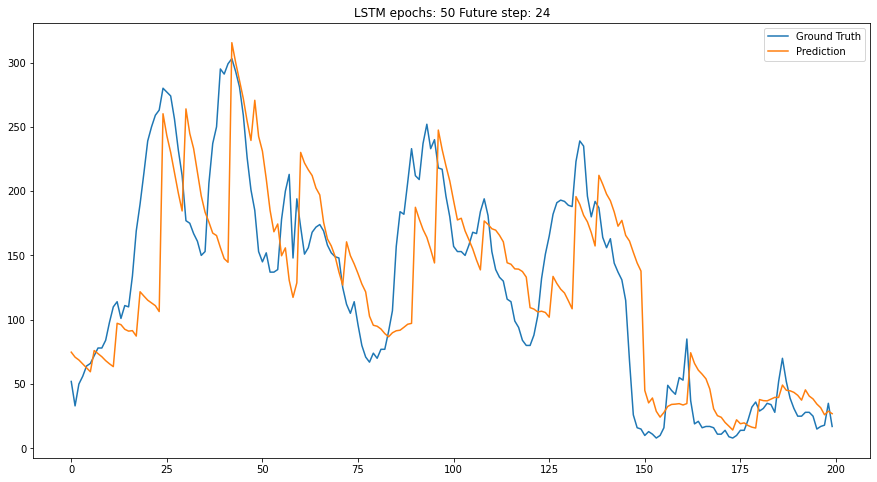

pastStep:  24  futureStep:  7 (39414, 1, 192) (39414, 7) (4380, 1, 192) (4380, 7)
Epoch 1/50
548/548 - 3s - loss: 0.0465 - val_loss: 0.0363
Epoch 2/50
548/548 - 1s - loss: 0.0374 - val_loss: 0.0347
Epoch 3/50
548/548 - 1s - loss: 0.0355 - val_loss: 0.0325
Epoch 4/50
548/548 - 1s - loss: 0.0346 - val_loss: 0.0313
Epoch 5/50
548/548 - 1s - loss: 0.0340 - val_loss: 0.0307
Epoch 6/50
548/548 - 1s - loss: 0.0337 - val_loss: 0.0303
Epoch 7/50
548/548 - 1s - loss: 0.0333 - val_loss: 0.0300
Epoch 8/50
548/548 - 1s - loss: 0.0330 - val_loss: 0.0296
Epoch 9/50
548/548 - 1s - loss: 0.0327 - val_loss: 0.0294
Epoch 10/50
548/548 - 1s - loss: 0.0324 - val_loss: 0.0292
Epoch 11/50
548/548 - 1s - loss: 0.0322 - val_loss: 0.0290
Epoch 12/50
548/548 - 1s - loss: 0.0320 - val_loss: 0.0288
Epoch 13/50
548/548 - 1s - loss: 0.0317 - val_loss: 0.0286
Epoch 14/50
548/548 - 1s - loss: 0.0316 - val_loss: 0.0285
Epoch 15/50
548/548 - 1s - loss: 0.0315 - val_loss: 0.0284
Epoch 16/50
548/548 - 1s - loss: 0.0312 - 

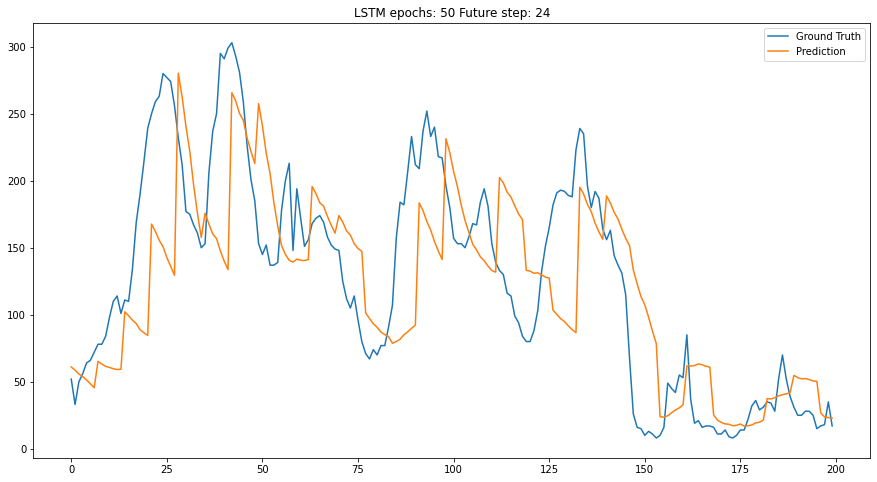

pastStep:  24  futureStep:  8 (39413, 1, 192) (39413, 8) (4380, 1, 192) (4380, 8)
Epoch 1/50
548/548 - 3s - loss: 0.0487 - val_loss: 0.0379
Epoch 2/50
548/548 - 1s - loss: 0.0392 - val_loss: 0.0345
Epoch 3/50
548/548 - 1s - loss: 0.0374 - val_loss: 0.0330
Epoch 4/50
548/548 - 1s - loss: 0.0363 - val_loss: 0.0324
Epoch 5/50
548/548 - 1s - loss: 0.0356 - val_loss: 0.0320
Epoch 6/50
548/548 - 1s - loss: 0.0351 - val_loss: 0.0316
Epoch 7/50
548/548 - 1s - loss: 0.0347 - val_loss: 0.0313
Epoch 8/50
548/548 - 1s - loss: 0.0344 - val_loss: 0.0310
Epoch 9/50
548/548 - 1s - loss: 0.0342 - val_loss: 0.0308
Epoch 10/50
548/548 - 1s - loss: 0.0340 - val_loss: 0.0306
Epoch 11/50
548/548 - 1s - loss: 0.0337 - val_loss: 0.0304
Epoch 12/50
548/548 - 1s - loss: 0.0335 - val_loss: 0.0302
Epoch 13/50
548/548 - 1s - loss: 0.0334 - val_loss: 0.0301
Epoch 14/50
548/548 - 1s - loss: 0.0332 - val_loss: 0.0299
Epoch 15/50
548/548 - 1s - loss: 0.0330 - val_loss: 0.0298
Epoch 16/50
548/548 - 1s - loss: 0.0328 - 

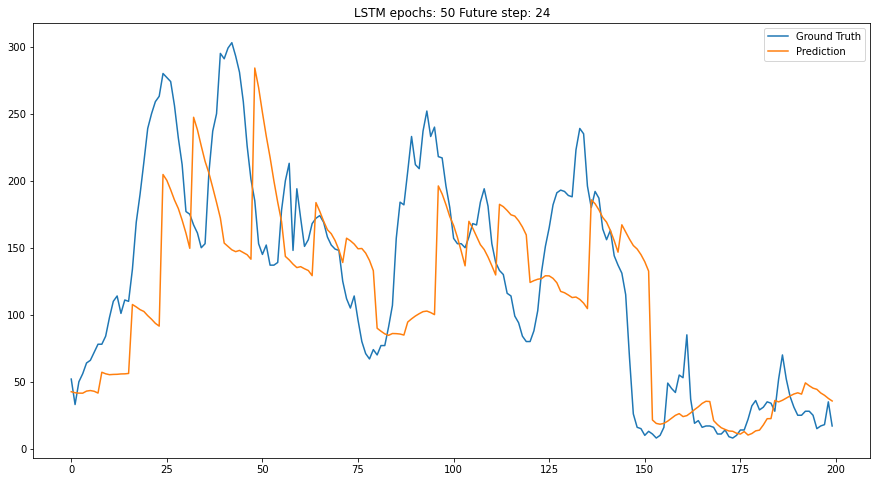

pastStep:  24  futureStep:  9 (39412, 1, 192) (39412, 9) (4380, 1, 192) (4380, 9)
Epoch 1/50
548/548 - 3s - loss: 0.0497 - val_loss: 0.0401
Epoch 2/50
548/548 - 1s - loss: 0.0404 - val_loss: 0.0363
Epoch 3/50
548/548 - 1s - loss: 0.0389 - val_loss: 0.0346
Epoch 4/50
548/548 - 1s - loss: 0.0379 - val_loss: 0.0342
Epoch 5/50
548/548 - 1s - loss: 0.0373 - val_loss: 0.0338
Epoch 6/50
548/548 - 1s - loss: 0.0368 - val_loss: 0.0334
Epoch 7/50
548/548 - 1s - loss: 0.0364 - val_loss: 0.0330
Epoch 8/50
548/548 - 1s - loss: 0.0360 - val_loss: 0.0327
Epoch 9/50
548/548 - 1s - loss: 0.0358 - val_loss: 0.0324
Epoch 10/50
548/548 - 1s - loss: 0.0355 - val_loss: 0.0322
Epoch 11/50
548/548 - 1s - loss: 0.0353 - val_loss: 0.0320
Epoch 12/50
548/548 - 1s - loss: 0.0351 - val_loss: 0.0318
Epoch 13/50
548/548 - 1s - loss: 0.0349 - val_loss: 0.0317
Epoch 14/50
548/548 - 1s - loss: 0.0347 - val_loss: 0.0315
Epoch 15/50
548/548 - 1s - loss: 0.0346 - val_loss: 0.0314
Epoch 16/50
548/548 - 1s - loss: 0.0344 - 

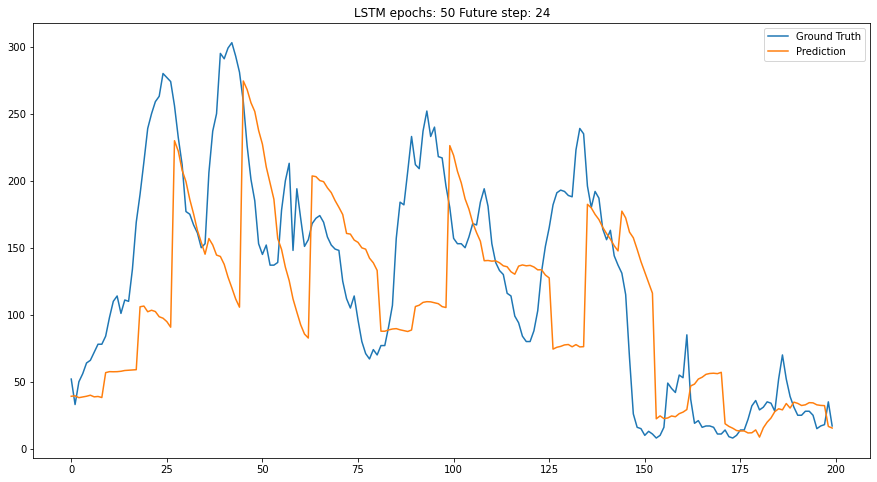

pastStep:  24  futureStep:  10 (39411, 1, 192) (39411, 10) (4380, 1, 192) (4380, 10)
Epoch 1/50
548/548 - 4s - loss: 0.0510 - val_loss: 0.0400
Epoch 2/50
548/548 - 1s - loss: 0.0419 - val_loss: 0.0370
Epoch 3/50
548/548 - 1s - loss: 0.0402 - val_loss: 0.0360
Epoch 4/50
548/548 - 1s - loss: 0.0393 - val_loss: 0.0353
Epoch 5/50
548/548 - 1s - loss: 0.0387 - val_loss: 0.0349
Epoch 6/50
548/548 - 1s - loss: 0.0382 - val_loss: 0.0345
Epoch 7/50
548/548 - 1s - loss: 0.0379 - val_loss: 0.0341
Epoch 8/50
548/548 - 1s - loss: 0.0375 - val_loss: 0.0338
Epoch 9/50
548/548 - 1s - loss: 0.0373 - val_loss: 0.0336
Epoch 10/50
548/548 - 1s - loss: 0.0370 - val_loss: 0.0334
Epoch 11/50
548/548 - 1s - loss: 0.0369 - val_loss: 0.0332
Epoch 12/50
548/548 - 1s - loss: 0.0367 - val_loss: 0.0331
Epoch 13/50
548/548 - 1s - loss: 0.0365 - val_loss: 0.0329
Epoch 14/50
548/548 - 1s - loss: 0.0363 - val_loss: 0.0328
Epoch 15/50
548/548 - 1s - loss: 0.0361 - val_loss: 0.0327
Epoch 16/50
548/548 - 1s - loss: 0.0360

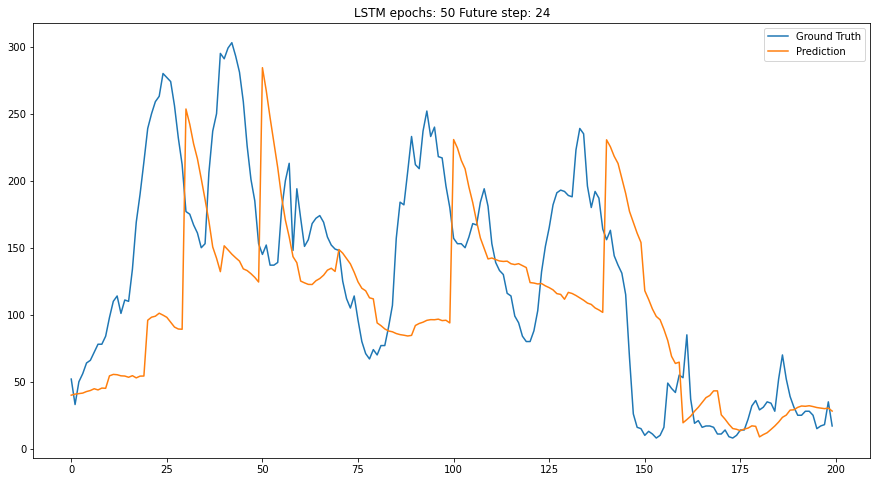

pastStep:  24  futureStep:  11 (39411, 1, 192) (39411, 11) (4379, 1, 192) (4379, 11)
Epoch 1/50
548/548 - 3s - loss: 0.0512 - val_loss: 0.0418
Epoch 2/50
548/548 - 1s - loss: 0.0430 - val_loss: 0.0391
Epoch 3/50
548/548 - 1s - loss: 0.0416 - val_loss: 0.0381
Epoch 4/50
548/548 - 1s - loss: 0.0407 - val_loss: 0.0373
Epoch 5/50
548/548 - 1s - loss: 0.0400 - val_loss: 0.0367
Epoch 6/50
548/548 - 1s - loss: 0.0395 - val_loss: 0.0362
Epoch 7/50
548/548 - 1s - loss: 0.0391 - val_loss: 0.0359
Epoch 8/50
548/548 - 1s - loss: 0.0388 - val_loss: 0.0356
Epoch 9/50
548/548 - 1s - loss: 0.0385 - val_loss: 0.0354
Epoch 10/50
548/548 - 1s - loss: 0.0382 - val_loss: 0.0352
Epoch 11/50
548/548 - 1s - loss: 0.0380 - val_loss: 0.0352
Epoch 12/50
548/548 - 1s - loss: 0.0378 - val_loss: 0.0352
Epoch 13/50
548/548 - 1s - loss: 0.0375 - val_loss: 0.0351
Epoch 14/50
548/548 - 1s - loss: 0.0373 - val_loss: 0.0350
Epoch 15/50
548/548 - 1s - loss: 0.0372 - val_loss: 0.0350
Epoch 16/50
548/548 - 1s - loss: 0.0370

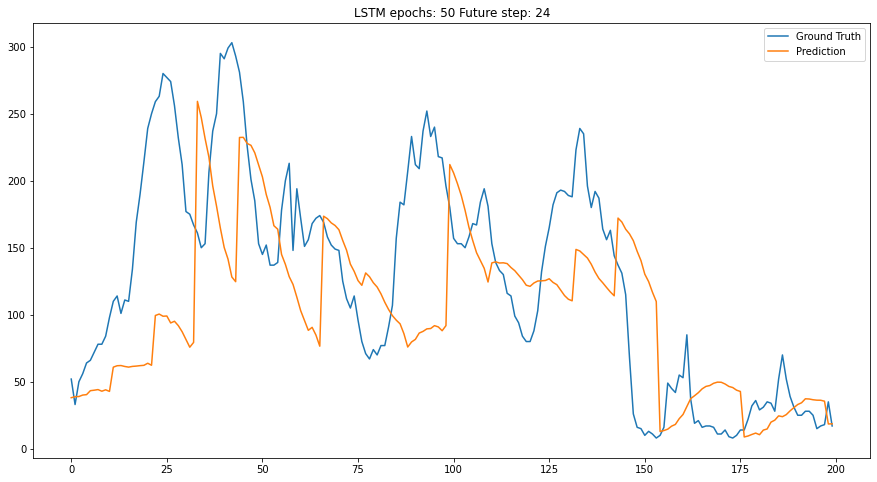

pastStep:  24  futureStep:  12 (39410, 1, 192) (39410, 12) (4379, 1, 192) (4379, 12)
Epoch 1/50
548/548 - 4s - loss: 0.0513 - val_loss: 0.0428
Epoch 2/50
548/548 - 1s - loss: 0.0441 - val_loss: 0.0402
Epoch 3/50
548/548 - 1s - loss: 0.0427 - val_loss: 0.0389
Epoch 4/50
548/548 - 1s - loss: 0.0419 - val_loss: 0.0381
Epoch 5/50
548/548 - 1s - loss: 0.0413 - val_loss: 0.0377
Epoch 6/50
548/548 - 1s - loss: 0.0409 - val_loss: 0.0373
Epoch 7/50
548/548 - 1s - loss: 0.0405 - val_loss: 0.0370
Epoch 8/50
548/548 - 1s - loss: 0.0402 - val_loss: 0.0367
Epoch 9/50
548/548 - 1s - loss: 0.0399 - val_loss: 0.0365
Epoch 10/50
548/548 - 1s - loss: 0.0397 - val_loss: 0.0366
Epoch 11/50
548/548 - 1s - loss: 0.0395 - val_loss: 0.0365
Epoch 12/50
548/548 - 1s - loss: 0.0393 - val_loss: 0.0365
Epoch 13/50
548/548 - 1s - loss: 0.0391 - val_loss: 0.0366
Epoch 14/50
548/548 - 1s - loss: 0.0389 - val_loss: 0.0367
Epoch 15/50
548/548 - 1s - loss: 0.0388 - val_loss: 0.0365
Epoch 16/50
548/548 - 1s - loss: 0.0387

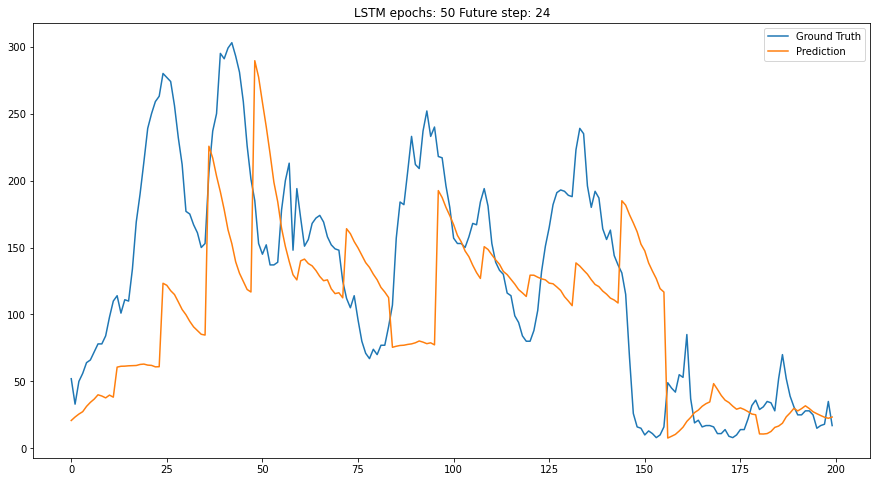

pastStep:  24  futureStep:  13 (39409, 1, 192) (39409, 13) (4379, 1, 192) (4379, 13)
Epoch 1/50
548/548 - 3s - loss: 0.0528 - val_loss: 0.0437
Epoch 2/50
548/548 - 1s - loss: 0.0454 - val_loss: 0.0408
Epoch 3/50
548/548 - 1s - loss: 0.0438 - val_loss: 0.0394
Epoch 4/50
548/548 - 1s - loss: 0.0429 - val_loss: 0.0386
Epoch 5/50
548/548 - 1s - loss: 0.0422 - val_loss: 0.0381
Epoch 6/50
548/548 - 1s - loss: 0.0418 - val_loss: 0.0377
Epoch 7/50
548/548 - 1s - loss: 0.0414 - val_loss: 0.0375
Epoch 8/50
548/548 - 1s - loss: 0.0411 - val_loss: 0.0373
Epoch 9/50
548/548 - 1s - loss: 0.0409 - val_loss: 0.0372
Epoch 10/50
548/548 - 1s - loss: 0.0406 - val_loss: 0.0371
Epoch 11/50
548/548 - 1s - loss: 0.0405 - val_loss: 0.0372
Epoch 12/50
548/548 - 1s - loss: 0.0403 - val_loss: 0.0371
Epoch 13/50
548/548 - 1s - loss: 0.0401 - val_loss: 0.0373
Epoch 14/50
548/548 - 1s - loss: 0.0400 - val_loss: 0.0371
Epoch 15/50
548/548 - 1s - loss: 0.0398 - val_loss: 0.0371
Epoch 16/50
548/548 - 1s - loss: 0.0397

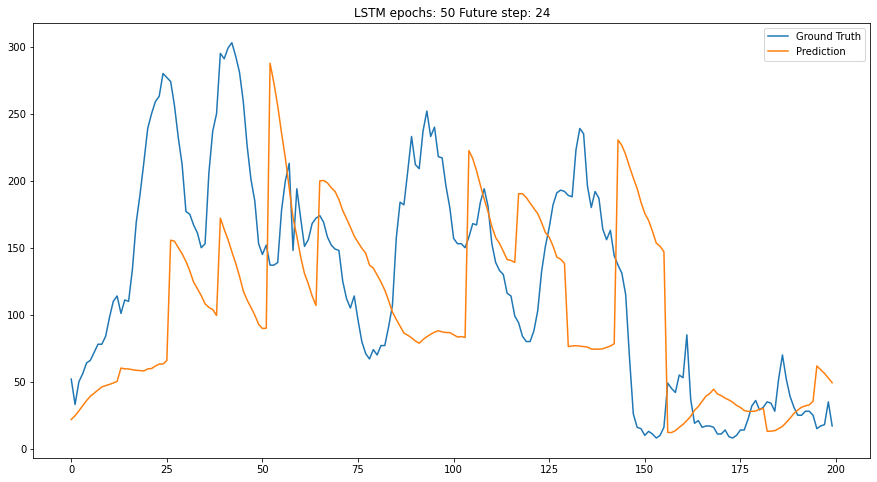

pastStep:  24  futureStep:  14 (39408, 1, 192) (39408, 14) (4379, 1, 192) (4379, 14)
Epoch 1/50
548/548 - 4s - loss: 0.0539 - val_loss: 0.0456
Epoch 2/50
548/548 - 1s - loss: 0.0465 - val_loss: 0.0436
Epoch 3/50
548/548 - 1s - loss: 0.0450 - val_loss: 0.0417
Epoch 4/50
548/548 - 1s - loss: 0.0439 - val_loss: 0.0405
Epoch 5/50
548/548 - 1s - loss: 0.0433 - val_loss: 0.0397
Epoch 6/50
548/548 - 1s - loss: 0.0428 - val_loss: 0.0391
Epoch 7/50
548/548 - 1s - loss: 0.0424 - val_loss: 0.0388
Epoch 8/50
548/548 - 1s - loss: 0.0421 - val_loss: 0.0385
Epoch 9/50
548/548 - 1s - loss: 0.0418 - val_loss: 0.0384
Epoch 10/50
548/548 - 1s - loss: 0.0416 - val_loss: 0.0383
Epoch 11/50
548/548 - 1s - loss: 0.0414 - val_loss: 0.0381
Epoch 12/50
548/548 - 1s - loss: 0.0412 - val_loss: 0.0380
Epoch 13/50
548/548 - 1s - loss: 0.0411 - val_loss: 0.0380
Epoch 14/50
548/548 - 1s - loss: 0.0409 - val_loss: 0.0379
Epoch 15/50
548/548 - 1s - loss: 0.0407 - val_loss: 0.0377
Epoch 16/50
548/548 - 1s - loss: 0.0406

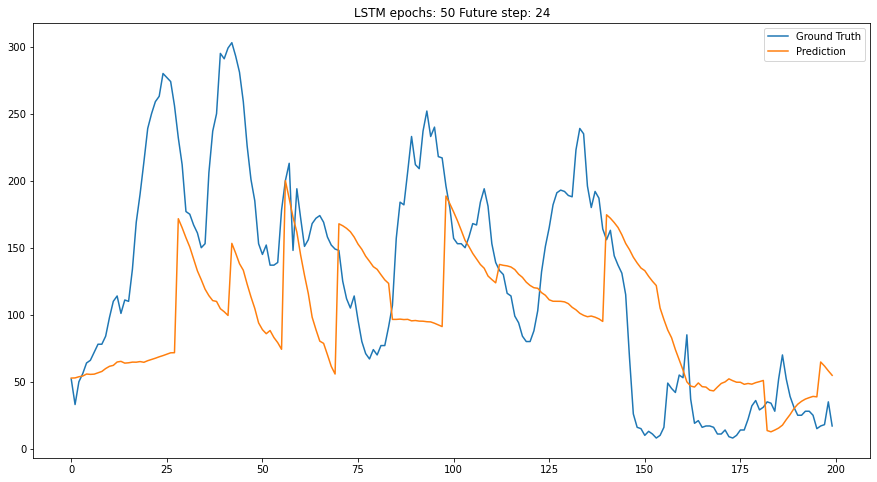

pastStep:  24  futureStep:  15 (39407, 1, 192) (39407, 15) (4379, 1, 192) (4379, 15)
Epoch 1/50
548/548 - 3s - loss: 0.0544 - val_loss: 0.0455
Epoch 2/50
548/548 - 1s - loss: 0.0472 - val_loss: 0.0430
Epoch 3/50
548/548 - 1s - loss: 0.0458 - val_loss: 0.0419
Epoch 4/50
548/548 - 1s - loss: 0.0449 - val_loss: 0.0411
Epoch 5/50
548/548 - 1s - loss: 0.0443 - val_loss: 0.0407
Epoch 6/50
548/548 - 1s - loss: 0.0439 - val_loss: 0.0403
Epoch 7/50
548/548 - 1s - loss: 0.0435 - val_loss: 0.0401
Epoch 8/50
548/548 - 1s - loss: 0.0432 - val_loss: 0.0398
Epoch 9/50
548/548 - 1s - loss: 0.0430 - val_loss: 0.0396
Epoch 10/50
548/548 - 1s - loss: 0.0428 - val_loss: 0.0395
Epoch 11/50
548/548 - 1s - loss: 0.0426 - val_loss: 0.0393
Epoch 12/50
548/548 - 1s - loss: 0.0424 - val_loss: 0.0392
Epoch 13/50
548/548 - 1s - loss: 0.0423 - val_loss: 0.0389
Epoch 14/50
548/548 - 1s - loss: 0.0421 - val_loss: 0.0389
Epoch 15/50
548/548 - 1s - loss: 0.0420 - val_loss: 0.0387
Epoch 16/50
548/548 - 1s - loss: 0.0418

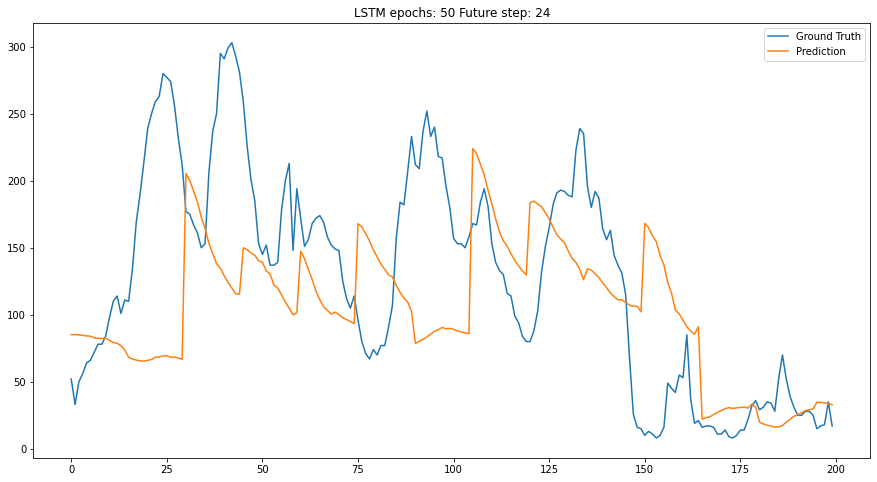

pastStep:  24  futureStep:  16 (39406, 1, 192) (39406, 16) (4379, 1, 192) (4379, 16)
Epoch 1/50
548/548 - 4s - loss: 0.0559 - val_loss: 0.0478
Epoch 2/50
548/548 - 1s - loss: 0.0483 - val_loss: 0.0452
Epoch 3/50
548/548 - 1s - loss: 0.0467 - val_loss: 0.0436
Epoch 4/50
548/548 - 1s - loss: 0.0458 - val_loss: 0.0425
Epoch 5/50
548/548 - 1s - loss: 0.0452 - val_loss: 0.0418
Epoch 6/50
548/548 - 1s - loss: 0.0447 - val_loss: 0.0413
Epoch 7/50
548/548 - 1s - loss: 0.0444 - val_loss: 0.0409
Epoch 8/50
548/548 - 1s - loss: 0.0441 - val_loss: 0.0406
Epoch 9/50
548/548 - 1s - loss: 0.0438 - val_loss: 0.0403
Epoch 10/50
548/548 - 1s - loss: 0.0436 - val_loss: 0.0401
Epoch 11/50
548/548 - 1s - loss: 0.0434 - val_loss: 0.0400
Epoch 12/50
548/548 - 1s - loss: 0.0432 - val_loss: 0.0398
Epoch 13/50
548/548 - 1s - loss: 0.0431 - val_loss: 0.0397
Epoch 14/50
548/548 - 1s - loss: 0.0429 - val_loss: 0.0396
Epoch 15/50
548/548 - 1s - loss: 0.0428 - val_loss: 0.0395
Epoch 16/50
548/548 - 1s - loss: 0.0427

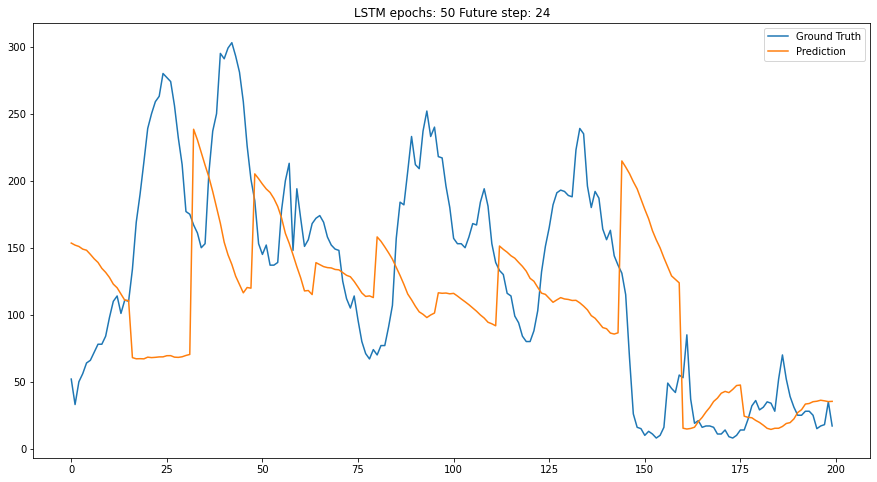

pastStep:  24  futureStep:  17 (39405, 1, 192) (39405, 17) (4379, 1, 192) (4379, 17)
Epoch 1/50
548/548 - 3s - loss: 0.0565 - val_loss: 0.0473
Epoch 2/50
548/548 - 1s - loss: 0.0490 - val_loss: 0.0454
Epoch 3/50
548/548 - 1s - loss: 0.0477 - val_loss: 0.0447
Epoch 4/50
548/548 - 1s - loss: 0.0468 - val_loss: 0.0438
Epoch 5/50
548/548 - 1s - loss: 0.0462 - val_loss: 0.0432
Epoch 6/50
548/548 - 1s - loss: 0.0458 - val_loss: 0.0426
Epoch 7/50
548/548 - 1s - loss: 0.0454 - val_loss: 0.0422
Epoch 8/50
548/548 - 1s - loss: 0.0451 - val_loss: 0.0419
Epoch 9/50
548/548 - 1s - loss: 0.0448 - val_loss: 0.0416
Epoch 10/50
548/548 - 1s - loss: 0.0446 - val_loss: 0.0413
Epoch 11/50
548/548 - 1s - loss: 0.0444 - val_loss: 0.0411
Epoch 12/50
548/548 - 1s - loss: 0.0442 - val_loss: 0.0410
Epoch 13/50
548/548 - 1s - loss: 0.0441 - val_loss: 0.0408
Epoch 14/50
548/548 - 1s - loss: 0.0439 - val_loss: 0.0407
Epoch 15/50
548/548 - 1s - loss: 0.0438 - val_loss: 0.0406
Epoch 16/50
548/548 - 1s - loss: 0.0436

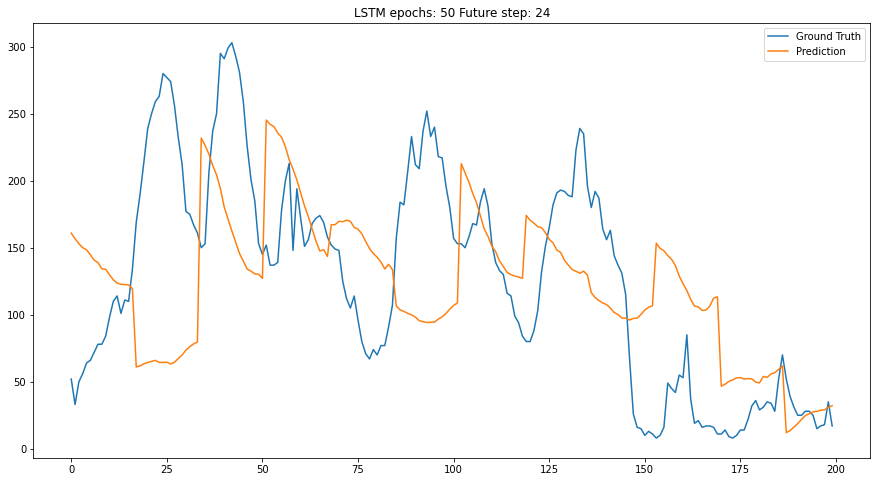

pastStep:  24  futureStep:  18 (39404, 1, 192) (39404, 18) (4379, 1, 192) (4379, 18)
Epoch 1/50
548/548 - 3s - loss: 0.0557 - val_loss: 0.0474
Epoch 2/50
548/548 - 1s - loss: 0.0497 - val_loss: 0.0456
Epoch 3/50
548/548 - 1s - loss: 0.0484 - val_loss: 0.0444
Epoch 4/50
548/548 - 1s - loss: 0.0476 - val_loss: 0.0436
Epoch 5/50
548/548 - 1s - loss: 0.0470 - val_loss: 0.0430
Epoch 6/50
548/548 - 1s - loss: 0.0465 - val_loss: 0.0427
Epoch 7/50
548/548 - 1s - loss: 0.0462 - val_loss: 0.0424
Epoch 8/50
548/548 - 1s - loss: 0.0459 - val_loss: 0.0422
Epoch 9/50
548/548 - 1s - loss: 0.0456 - val_loss: 0.0420
Epoch 10/50
548/548 - 1s - loss: 0.0454 - val_loss: 0.0419
Epoch 11/50
548/548 - 1s - loss: 0.0452 - val_loss: 0.0417
Epoch 12/50
548/548 - 1s - loss: 0.0451 - val_loss: 0.0415
Epoch 13/50
548/548 - 1s - loss: 0.0449 - val_loss: 0.0414
Epoch 14/50
548/548 - 1s - loss: 0.0447 - val_loss: 0.0412
Epoch 15/50
548/548 - 1s - loss: 0.0446 - val_loss: 0.0411
Epoch 16/50
548/548 - 1s - loss: 0.0444

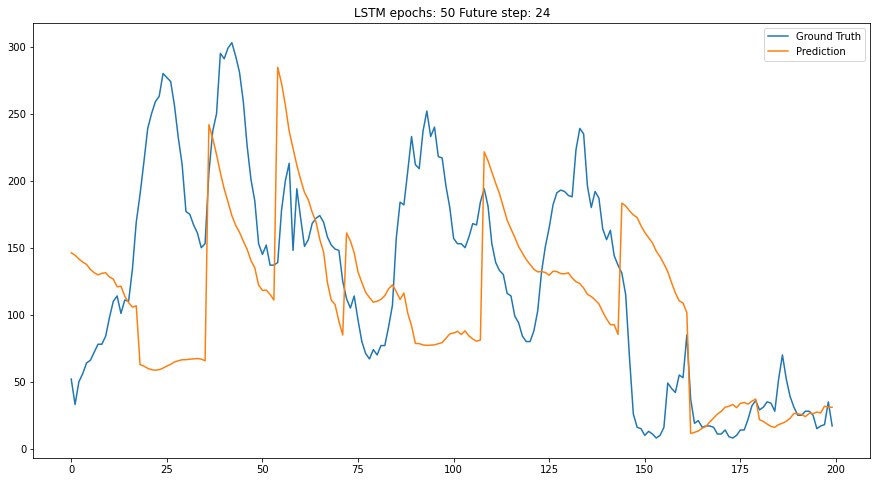

pastStep:  24  futureStep:  19 (39403, 1, 192) (39403, 19) (4379, 1, 192) (4379, 19)
Epoch 1/50
548/548 - 3s - loss: 0.0571 - val_loss: 0.0486
Epoch 2/50
548/548 - 1s - loss: 0.0505 - val_loss: 0.0471
Epoch 3/50
548/548 - 1s - loss: 0.0492 - val_loss: 0.0463
Epoch 4/50
548/548 - 1s - loss: 0.0484 - val_loss: 0.0454
Epoch 5/50
548/548 - 1s - loss: 0.0478 - val_loss: 0.0445
Epoch 6/50
548/548 - 1s - loss: 0.0474 - val_loss: 0.0439
Epoch 7/50
548/548 - 1s - loss: 0.0470 - val_loss: 0.0434
Epoch 8/50
548/548 - 1s - loss: 0.0467 - val_loss: 0.0431
Epoch 9/50
548/548 - 1s - loss: 0.0465 - val_loss: 0.0428
Epoch 10/50
548/548 - 1s - loss: 0.0462 - val_loss: 0.0426
Epoch 11/50
548/548 - 1s - loss: 0.0460 - val_loss: 0.0424
Epoch 12/50
548/548 - 1s - loss: 0.0459 - val_loss: 0.0423
Epoch 13/50
548/548 - 1s - loss: 0.0457 - val_loss: 0.0421
Epoch 14/50
548/548 - 1s - loss: 0.0456 - val_loss: 0.0420
Epoch 15/50
548/548 - 1s - loss: 0.0454 - val_loss: 0.0419
Epoch 16/50
548/548 - 1s - loss: 0.0453

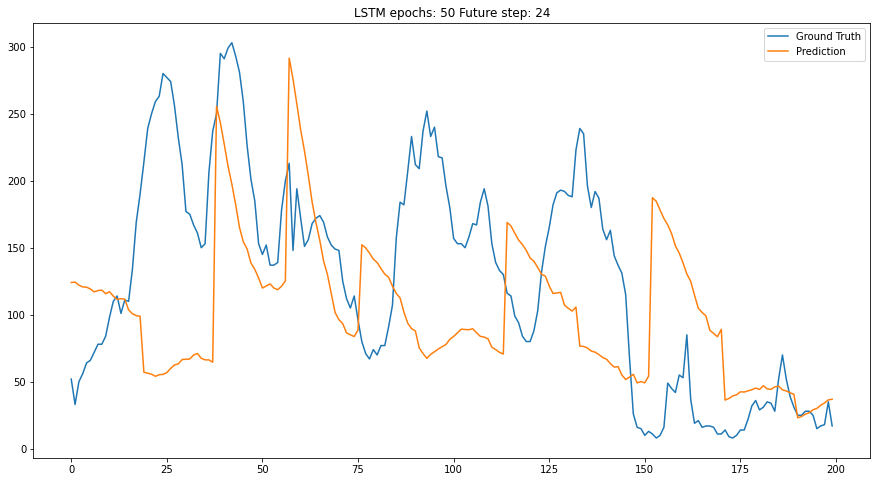

pastStep:  24  futureStep:  20 (39402, 1, 192) (39402, 20) (4379, 1, 192) (4379, 20)
Epoch 1/50
548/548 - 3s - loss: 0.0575 - val_loss: 0.0496
Epoch 2/50
548/548 - 1s - loss: 0.0510 - val_loss: 0.0473
Epoch 3/50
548/548 - 1s - loss: 0.0497 - val_loss: 0.0464
Epoch 4/50
548/548 - 1s - loss: 0.0490 - val_loss: 0.0456
Epoch 5/50
548/548 - 1s - loss: 0.0484 - val_loss: 0.0449
Epoch 6/50
548/548 - 1s - loss: 0.0479 - val_loss: 0.0444
Epoch 7/50
548/548 - 1s - loss: 0.0475 - val_loss: 0.0440
Epoch 8/50
548/548 - 1s - loss: 0.0472 - val_loss: 0.0438
Epoch 9/50
548/548 - 1s - loss: 0.0470 - val_loss: 0.0435
Epoch 10/50
548/548 - 1s - loss: 0.0467 - val_loss: 0.0433
Epoch 11/50
548/548 - 1s - loss: 0.0466 - val_loss: 0.0432
Epoch 12/50
548/548 - 1s - loss: 0.0464 - val_loss: 0.0430
Epoch 13/50
548/548 - 1s - loss: 0.0462 - val_loss: 0.0428
Epoch 14/50
548/548 - 1s - loss: 0.0461 - val_loss: 0.0427
Epoch 15/50
548/548 - 1s - loss: 0.0459 - val_loss: 0.0425
Epoch 16/50
548/548 - 1s - loss: 0.0458

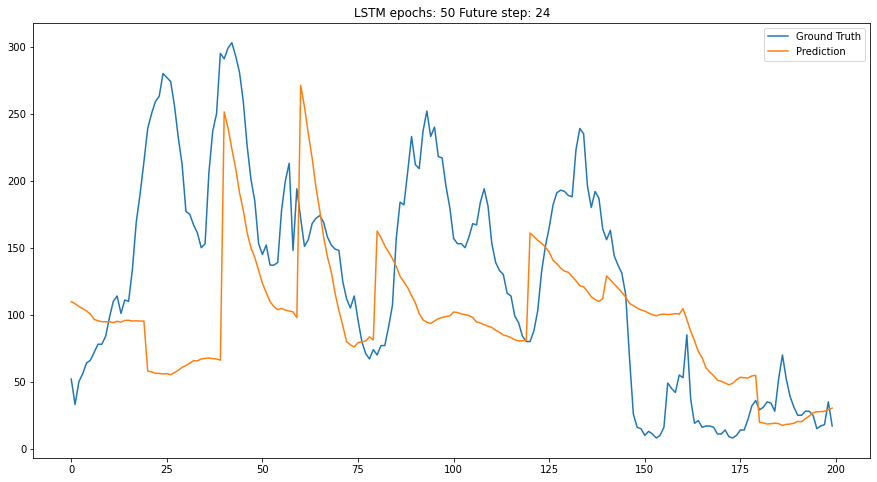

pastStep:  24  futureStep:  21 (39402, 1, 192) (39402, 21) (4378, 1, 192) (4378, 21)
Epoch 1/50
548/548 - 4s - loss: 0.0582 - val_loss: 0.0493
Epoch 2/50
548/548 - 1s - loss: 0.0515 - val_loss: 0.0476
Epoch 3/50
548/548 - 1s - loss: 0.0503 - val_loss: 0.0471
Epoch 4/50
548/548 - 1s - loss: 0.0496 - val_loss: 0.0463
Epoch 5/50
548/548 - 1s - loss: 0.0491 - val_loss: 0.0457
Epoch 6/50
548/548 - 1s - loss: 0.0487 - val_loss: 0.0452
Epoch 7/50
548/548 - 1s - loss: 0.0483 - val_loss: 0.0448
Epoch 8/50
548/548 - 1s - loss: 0.0481 - val_loss: 0.0446
Epoch 9/50
548/548 - 1s - loss: 0.0478 - val_loss: 0.0443
Epoch 10/50
548/548 - 1s - loss: 0.0476 - val_loss: 0.0442
Epoch 11/50
548/548 - 1s - loss: 0.0475 - val_loss: 0.0441
Epoch 12/50
548/548 - 1s - loss: 0.0473 - val_loss: 0.0440
Epoch 13/50
548/548 - 1s - loss: 0.0471 - val_loss: 0.0439
Epoch 14/50
548/548 - 1s - loss: 0.0470 - val_loss: 0.0437
Epoch 15/50
548/548 - 1s - loss: 0.0468 - val_loss: 0.0436
Epoch 16/50
548/548 - 1s - loss: 0.0467

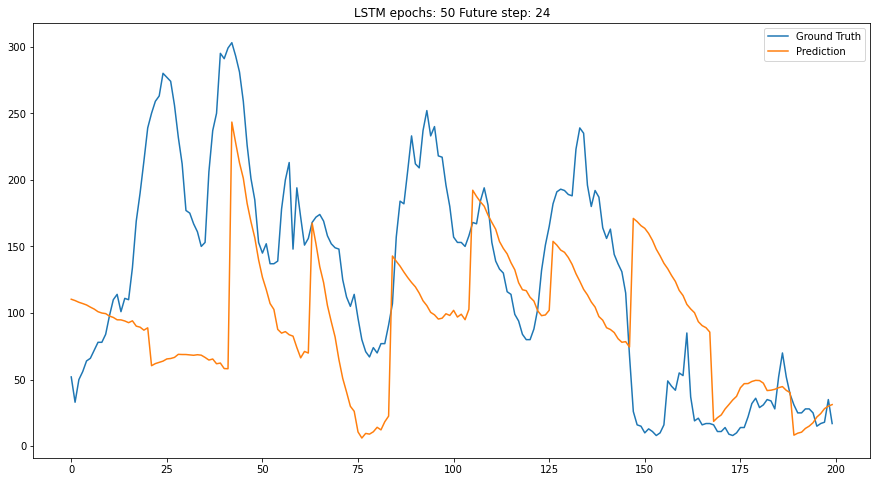

pastStep:  24  futureStep:  22 (39401, 1, 192) (39401, 22) (4378, 1, 192) (4378, 22)
Epoch 1/50
548/548 - 3s - loss: 0.0575 - val_loss: 0.0502
Epoch 2/50
548/548 - 1s - loss: 0.0520 - val_loss: 0.0491
Epoch 3/50
548/548 - 1s - loss: 0.0509 - val_loss: 0.0484
Epoch 4/50
548/548 - 1s - loss: 0.0502 - val_loss: 0.0475
Epoch 5/50
548/548 - 1s - loss: 0.0497 - val_loss: 0.0468
Epoch 6/50
548/548 - 1s - loss: 0.0493 - val_loss: 0.0462
Epoch 7/50
548/548 - 1s - loss: 0.0489 - val_loss: 0.0458
Epoch 8/50
548/548 - 1s - loss: 0.0486 - val_loss: 0.0455
Epoch 9/50
548/548 - 1s - loss: 0.0484 - val_loss: 0.0452
Epoch 10/50
548/548 - 1s - loss: 0.0481 - val_loss: 0.0449
Epoch 11/50
548/548 - 1s - loss: 0.0480 - val_loss: 0.0447
Epoch 12/50
548/548 - 1s - loss: 0.0478 - val_loss: 0.0445
Epoch 13/50
548/548 - 1s - loss: 0.0476 - val_loss: 0.0443
Epoch 14/50
548/548 - 1s - loss: 0.0475 - val_loss: 0.0442
Epoch 15/50
548/548 - 1s - loss: 0.0473 - val_loss: 0.0440
Epoch 16/50
548/548 - 1s - loss: 0.0472

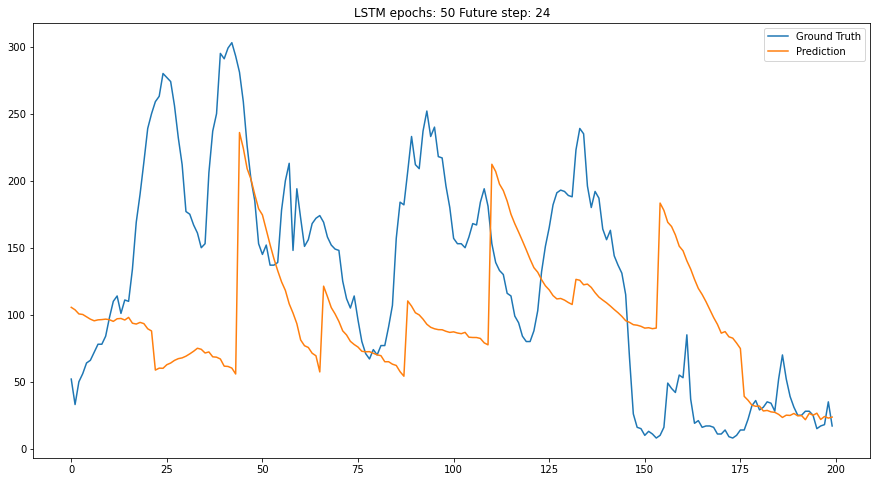

pastStep:  24  futureStep:  23 (39400, 1, 192) (39400, 23) (4378, 1, 192) (4378, 23)
Epoch 1/50
548/548 - 4s - loss: 0.0581 - val_loss: 0.0506
Epoch 2/50
548/548 - 1s - loss: 0.0525 - val_loss: 0.0497
Epoch 3/50
548/548 - 1s - loss: 0.0514 - val_loss: 0.0489
Epoch 4/50
548/548 - 1s - loss: 0.0508 - val_loss: 0.0480
Epoch 5/50
548/548 - 1s - loss: 0.0502 - val_loss: 0.0472
Epoch 6/50
548/548 - 1s - loss: 0.0497 - val_loss: 0.0467
Epoch 7/50
548/548 - 1s - loss: 0.0494 - val_loss: 0.0462
Epoch 8/50
548/548 - 1s - loss: 0.0491 - val_loss: 0.0459
Epoch 9/50
548/548 - 1s - loss: 0.0488 - val_loss: 0.0457
Epoch 10/50
548/548 - 1s - loss: 0.0486 - val_loss: 0.0455
Epoch 11/50
548/548 - 1s - loss: 0.0484 - val_loss: 0.0454
Epoch 12/50
548/548 - 1s - loss: 0.0482 - val_loss: 0.0452
Epoch 13/50
548/548 - 1s - loss: 0.0481 - val_loss: 0.0451
Epoch 14/50
548/548 - 1s - loss: 0.0479 - val_loss: 0.0450
Epoch 15/50
548/548 - 1s - loss: 0.0478 - val_loss: 0.0449
Epoch 16/50
548/548 - 1s - loss: 0.0477

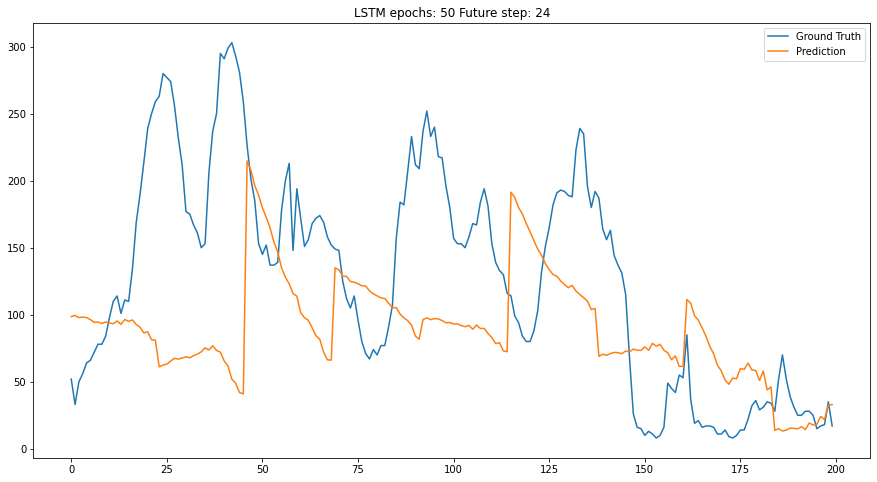

pastStep:  24  futureStep:  24 (39399, 1, 192) (39399, 24) (4378, 1, 192) (4378, 24)
Epoch 1/50
548/548 - 3s - loss: 0.0585 - val_loss: 0.0512
Epoch 2/50
548/548 - 1s - loss: 0.0532 - val_loss: 0.0502
Epoch 3/50
548/548 - 1s - loss: 0.0522 - val_loss: 0.0496
Epoch 4/50
548/548 - 1s - loss: 0.0515 - val_loss: 0.0492
Epoch 5/50
548/548 - 1s - loss: 0.0510 - val_loss: 0.0485
Epoch 6/50
548/548 - 1s - loss: 0.0506 - val_loss: 0.0478
Epoch 7/50
548/548 - 1s - loss: 0.0502 - val_loss: 0.0471
Epoch 8/50
548/548 - 1s - loss: 0.0499 - val_loss: 0.0466
Epoch 9/50
548/548 - 1s - loss: 0.0496 - val_loss: 0.0462
Epoch 10/50
548/548 - 1s - loss: 0.0493 - val_loss: 0.0459
Epoch 11/50
548/548 - 1s - loss: 0.0491 - val_loss: 0.0457
Epoch 12/50
548/548 - 1s - loss: 0.0489 - val_loss: 0.0455
Epoch 13/50
548/548 - 1s - loss: 0.0487 - val_loss: 0.0453
Epoch 14/50
548/548 - 1s - loss: 0.0485 - val_loss: 0.0452
Epoch 15/50
548/548 - 1s - loss: 0.0484 - val_loss: 0.0451
Epoch 16/50
548/548 - 1s - loss: 0.0482

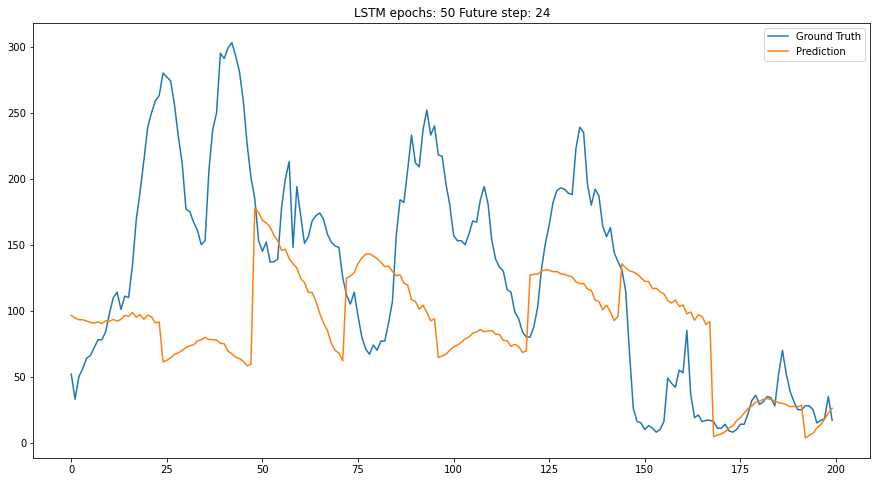

In [29]:
pastStep = 24
maxFutureStep = 24

for futureStep in range(1, maxFutureStep+1):  # from 1 to 24
  # frame as supervised learning
  reframed = series_to_supervised(scaled, pastStep, futureStep)

  # split into train and test sets
  values = reframed.values

  # use first 90% data to train
  n_train_hours = int(len(values) * 0.9)
  train = values[:n_train_hours]
  test = values[n_train_hours:]

  # split into input and output
  train_X, train_y = train[:, :-futureStep], train[:, -futureStep:]
  test_X, test_y = test[:, :-futureStep:], test[:, -futureStep:]

  # reshape input to be 3D [samples, timesteps, features]
  train_X_reshape = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X_reshape = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

  print("pastStep: ", str(pastStep), " futureStep: ", str(futureStep), 
        train_X_reshape.shape, train_y.shape, test_X_reshape.shape, test_y.shape)
  
  # design network
  model = Sequential()
  model.add(LSTM(50, input_shape=(train_X_reshape.shape[1], train_X_reshape.shape[2])))
  model.add(Dense(futureStep))
  model.compile(loss='mae', optimizer='adam')

  epochs = 50 # modify here to choose training epoches
  model.fit(train_X_reshape, train_y, epochs=epochs, batch_size=72, validation_data=(test_X_reshape, test_y), verbose=2, shuffle=False)

  # prediction
  result = model.predict(test_X_reshape)

  # combine prediction results
  prediction = np.array([])
  for i in range(0, len(test_X), futureStep):
    prediction = np.append(prediction, result[i])

  prediction = prediction[:len(test_X)]
  y_true = y_true[:len(test_X)]

  # inverse transform prediction
  prediction = prediction.reshape((len(prediction), 1))
  inv_pred = concatenate((prediction, test_X[:, 1:8]), axis=1)
  inv_pred = scaler.inverse_transform(inv_pred)[:, 0]

  # calculate RMSE
  rmse = sqrt(mean_squared_error(y_true, inv_pred))
  print('Test RMSE: %.3f' % rmse)

  plt.figure(figsize=(15, 8))
  plt.plot(y_true[:200], label='Ground Truth')
  plt.plot(inv_pred[:200], label='Prediction')
  plt.title("LSTM epochs: " + str(epochs) + " Future step: " + str(futureStep))
  plt.legend()
  plt.show()

In [30]:
# # plot history
# plt.figure(figsize=(10,5))
# plt.plot(history.history['loss'], label='train loss')
# plt.plot(history.history['val_loss'], label='test loss')
# plt.title("LSTM epochs: " + str(epochs))
# plt.legend()
# plt.show()